# TimeSeries RL Agent Genetic Tuning Tutorial

Welcome to the genetic algorithm-based hyperparameter tuning tutorial! This notebook demonstrates how to use the GeneticTuner to find optimal hyperparameters for your TimeSeries RL Agent. The genetic tuner uses evolutionary algorithms with diversity scoring and simulated annealing to efficiently explore the parameter space.

This tutorial is divided into three main parts:

1. Setting Up and Configuring the Genetic Tuner
2. Running the Evolutionary Search
3. Training the Final Model with Best Parameters

Let's get started!

## Installation

First, let's install the required packages:

In [ ]:
%pip install timeseries-agent --quiet
%pip install lightning torch --quiet

## Part 1: Setting Up and Configuring the Genetic Tuner

### 1.1 Import Libraries

Let's start by importing all necessary libraries:

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader
import lightning as L
from lightning.pytorch import seed_everything

seed_everything(42, workers=True)  # sets seeds for numpy, torch and python.random

from timeseries_agent import SequentialTimeSeriesDataset, PolicyGradientAgent
from timeseries_agent.tuning import GeneticTuner
from timeseries_agent.data import create_random_walk

Seed set to 42


### 1.2 Create Sample Data

We'll load a sample random walk dataset from the data module:


Random Walk Dataset Shapes:
Train: (750, 2)
Test: (250, 2)


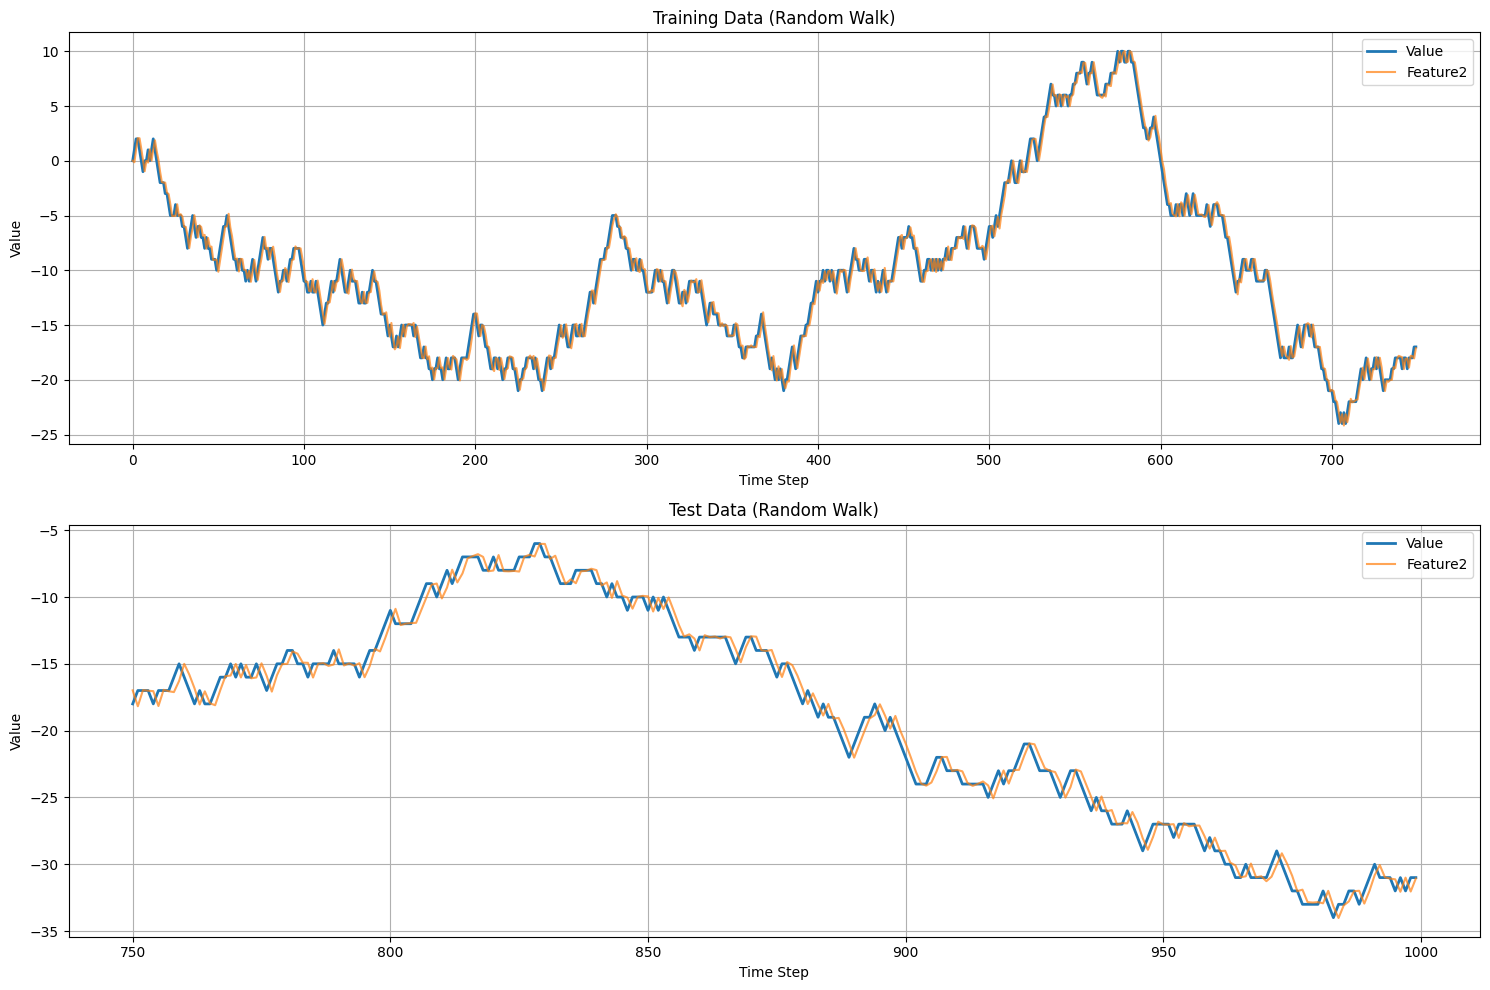

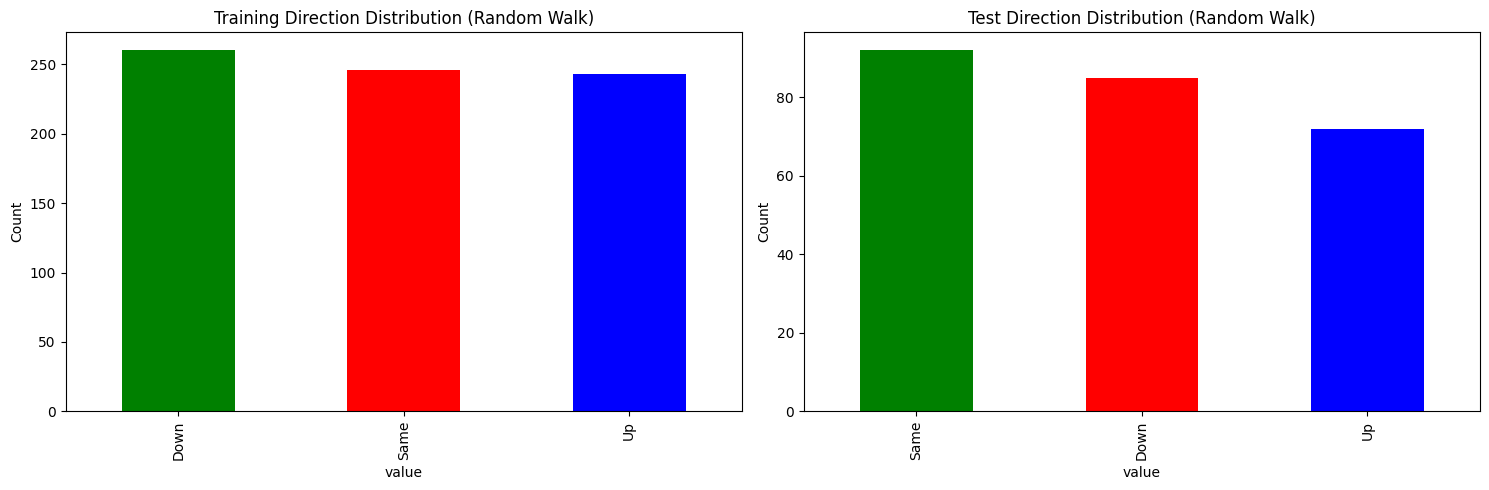

In [2]:
# Create random walk dataset
random_walk_data = create_random_walk(n_steps=1000, step_size=1.0, train_test_split=0.75)

print("\nRandom Walk Dataset Shapes:")
print(f"Train: {random_walk_data.train_df.shape}")
print(f"Test: {random_walk_data.test_df.shape}")

# Visualize random walk data
random_walk_data.plot_series()
random_walk_data.plot_directions()

# Use the training data for the agent
data_df = random_walk_data.train_df.copy()

### 1.3 Define Parameter Search Space and Genetic Algorithm Settings

Define the parameter ranges to explore and genetic algorithm configuration:

In [13]:
# Parameter grid to explore
params_grid = {
    'learning_rate': [0.001, 0.0005, 0.0001],       # Different learning rates
    'lookback': [5, 7, 10],                         # Different lookback periods
    'hidden_layers': [
        [100, 100, 10],                             # Network configuration 1
        [200, 100, 50],                             # Network configuration 2
        [150, 150, 50],                             # Network configuration 3
    ],
    'epsilon_start': [1.0, 0.9, 0.8],               # Different exploration start rates
    'epsilon_end': [0.01, 0.05, 0.1],               # Different exploration end rates
    'epsilon_decay_epochs_rate': [0.4, 0.5, 0.6],   # Different decay rates 
}

# Base parameters that will be the same for all models
base_params = {
    'normalize_state': True,                        # Normalize input states
    'eval_noise_factor': 0.1,                       # Add noise during evaluation
    'num_epochs': 10,                               # Number of training epochs
    'num_epochs_best_model': 100,                   # Number of epochs for the best model (learn more about this flag below)
}

# Genetic Algorithm Configuration
genetic_params = {
    'population_size': 10,                          # Size of each generation's population
    'num_generations': 5,                           # Number of generations to evolve
    'mutation_rate': 0.1,                           # Probability of parameter mutation
    'elitism_count': 1,                             # Number of best individuals to preserve
    'initial_temperature': 100.0,                   # Initial temperature for simulated annealing
    'cooling_rate': 0.95,                           # Rate at which temperature decreases
}

# Total number of candidate models to pick from the grid
num_models = np.prod([len(v) for v in params_grid.values()])
print(f"\nTotal number of candidate models: {num_models}")

# Total number of models to train by the genetic algorithm
num_models_to_train = genetic_params['population_size'] * genetic_params['num_generations']
print(f"Total number of models to train: {num_models_to_train}")

print("\nParameter Search Space:")
for param, values in params_grid.items():
    print(f"{param}: {values}")

print("\nBase Parameters:")
for param, value in base_params.items():
    print(f"{param}: {value}")

print("\nGenetic Algorithm Settings:")
for param, value in genetic_params.items():
    print(f"{param}: {value}")


Total number of candidate models: 729
Total number of models to train: 50

Parameter Search Space:
learning_rate: [0.001, 0.0005, 0.0001]
lookback: [5, 7, 10]
hidden_layers: [[100, 100, 10], [200, 100, 50], [150, 150, 50]]
epsilon_start: [1.0, 0.9, 0.8]
epsilon_end: [0.01, 0.05, 0.1]
epsilon_decay_epochs_rate: [0.4, 0.5, 0.6]

Base Parameters:
normalize_state: True
eval_noise_factor: 0.1
num_epochs: 10
num_epochs_best_model: 100

Genetic Algorithm Settings:
population_size: 10
num_generations: 5
mutation_rate: 0.1
elitism_count: 1
initial_temperature: 100.0
cooling_rate: 0.95


## Part 2: Running the Evolutionary Search

### 2.1 Initialize and Run the Genetic Tuner

Create the GeneticTuner with our evolutionary settings and start the search:

In [14]:
# Create genetic tuner instance
tuner = GeneticTuner(
    data_df=data_df,                            # DataFrame containing the training data
    base_log_dir="logs",                        # Directory to save logs and models
    target_column="value",                      # Target column in the dataset
    **genetic_params                            # Pass genetic algorithm configuration
)

# Train models using genetic algorithm optimization
print("\nStarting evolutionary search...")
results = tuner.train(
    params_grid=params_grid,
    base_params=base_params,
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytor


Starting evolutionary search...

Generation 1/5

Evaluating model 1/10
Parameters: {'learning_rate': 0.0001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.8, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.73it/s, v_num=2, train_reward=-0.328, train_loss=-0.345, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.72it/s, v_num=2, train_reward=-0.328, train_loss=-0.345, epsilon=0.050]

c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.



Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.27688172459602356
   val_pass_percentage      36.155914306640625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 2/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [150, 150, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.0 K | train
-----------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.72it/s, v_num=2, train_reward=-0.306, train_loss=-0.40, epsilon=0.100] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.0 K | train
-----------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.03494623675942421
   val_pass_percentage      48.252689361572266
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 3/10
Parameters: {'learning_rate': 0.0001, 'lookback': 5, 'hidden_layers': [150, 150, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.70it/s, v_num=2, train_reward=-0.266, train_loss=-0.261, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.3333333432674408
   val_pass_percentage       33.33333206176758
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 4/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.8, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.4}


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.73it/s, v_num=0, train_reward=-0.285, train_loss=-0.27, epsilon=0.100] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.6290322542190552
   val_pass_percentage       18.54838752746582
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 5/10
Parameters: {'learning_rate': 0.0001, 'lookback': 5, 'hidden_layers': [150, 150, 50], 'epsilon_start': 0.8, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.6}


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.0 K | train
-----------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.64it/s, v_num=0, train_reward=-0.32, train_loss=-0.319, epsilon=0.100] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.32258063554763794
   val_pass_percentage      33.870967864990234
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 6/10
Parameters: {'learning_rate': 0.0005, 'lookback': 5, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.8, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 27.5 K | train
-----------------------------------------------------
27.5 K    Trainable params
0         Non-trainable params
27.5 K    Total params
0.110     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.65it/s, v_num=0, train_reward=-0.347, train_loss=-0.299, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.5752688050270081
   val_pass_percentage       21.23655891418457
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 7/10
Parameters: {'learning_rate': 0.001, 'lookback': 10, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 29.5 K | train
-----------------------------------------------------
29.5 K    Trainable params
0         Non-trainable params
29.5 K    Total params
0.118     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.66it/s, v_num=0, train_reward=-0.286, train_loss=-0.522, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.49661704897880554
   val_pass_percentage       25.16914939880371
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 8/10
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.77it/s, v_num=0, train_reward=-0.299, train_loss=-0.243, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.6603773832321167
   val_pass_percentage       16.98113250732422
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 9/10
Parameters: {'learning_rate': 0.0005, 'lookback': 7, 'hidden_layers': [150, 150, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.6 K | train
-----------------------------------------------------
32.6 K    Trainable params
0         Non-trainable params
32.6 K    Total params
0.130     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.77it/s, v_num=0, train_reward=-0.313, train_loss=-0.0826, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.5229110717773438
   val_pass_percentage      23.854448318481445
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 10/10
Parameters: {'learning_rate': 0.0005, 'lookback': 10, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 13.2 K | train
-----------------------------------------------------
13.2 K    Trainable params
0         Non-trainable params
13.2 K    Total params
0.053     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.75it/s, v_num=0, train_reward=-0.237, train_loss=-0.124, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.37753722071647644
   val_pass_percentage      31.123138427734375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Generation 2/5

Evaluating model 1/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [150, 150, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.6}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.0 K | train
-----------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.48it/s, v_num=2, train_reward=-0.296, train_loss=-0.567, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward                -0.5
   val_pass_percentage             25.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 2/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.8, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.49it/s, v_num=2, train_reward=-0.328, train_loss=-0.349, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 29.5 K | train
-----------------------------------------------------
29.5 K    Trainable params
0         Non-trainable params
29.5 K    Total params
0.118     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.5833333134651184
   val_pass_percentage       20.83333396911621
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 3/10
Parameters: {'learning_rate': 0.001, 'lookback': 10, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.47it/s, v_num=2, train_reward=-0.386, train_loss=-0.561, epsilon=0.100] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.49932342767715454
   val_pass_percentage      25.033828735351562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 4/10
Parameters: {'learning_rate': 0.0001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.51it/s, v_num=0, train_reward=-0.333, train_loss=-0.344, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.6 K | train
-----------------------------------------------------
32.6 K    Trainable params
0         Non-trainable params
32.6 K    Total params
0.130     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.29032257199287415
   val_pass_percentage       35.48387145996094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 5/10
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [150, 150, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.45it/s, v_num=0, train_reward=-0.332, train_loss=-0.072, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.493261456489563
   val_pass_percentage      25.336929321289062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 6/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.8, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.45it/s, v_num=0, train_reward=-0.315, train_loss=-0.238, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4354838728904724
   val_pass_percentage      28.225807189941406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 7/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.8, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.47it/s, v_num=0, train_reward=-0.293, train_loss=-0.274, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 33.5 K | train
-----------------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.47580644488334656
   val_pass_percentage       26.20967674255371
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 8/10
Parameters: {'learning_rate': 0.0005, 'lookback': 10, 'hidden_layers': [150, 150, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.46it/s, v_num=0, train_reward=-0.299, train_loss=-0.142, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 29.5 K | train
-----------------------------------------------------
29.5 K    Trainable params
0         Non-trainable params
29.5 K    Total params
0.118     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.3991881012916565
   val_pass_percentage       30.04059600830078
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 9/10
Parameters: {'learning_rate': 0.001, 'lookback': 10, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.44it/s, v_num=0, train_reward=-0.361, train_loss=-0.378, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        0.033829499036073685
   val_pass_percentage       51.69147491455078
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 10/10
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.47it/s, v_num=0, train_reward=-0.353, train_loss=-0.301, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 29.5 K | train
-----------------------------------------------------
29.5 K    Trainable params
0         Non-trainable params
29.5 K    Total params
0.118     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4420485198497772
   val_pass_percentage      27.897573471069336
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Generation 3/5

Evaluating model 1/10
Parameters: {'learning_rate': 0.001, 'lookback': 10, 'hidden_layers': [200, 100, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.48it/s, v_num=0, train_reward=-0.34, train_loss=-0.44, epsilon=0.050]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.5588633418083191
   val_pass_percentage      22.056833267211914
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 2/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.8, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.46it/s, v_num=0, train_reward=-0.336, train_loss=-0.334, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.6827957034111023
   val_pass_percentage      15.860215187072754
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 3/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.46it/s, v_num=0, train_reward=-0.253, train_loss=-0.237, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.0 K | train
-----------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.3709677457809448
   val_pass_percentage       31.45161247253418
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 4/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [150, 150, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.46it/s, v_num=0, train_reward=-0.293, train_loss=-0.472, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.0 K | train
-----------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.5403226017951965
   val_pass_percentage      22.983871459960938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 5/10
Parameters: {'learning_rate': 0.0001, 'lookback': 5, 'hidden_layers': [150, 150, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.43it/s, v_num=0, train_reward=-0.333, train_loss=-0.408, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.6 K | train
-----------------------------------------------------
32.6 K    Trainable params
0         Non-trainable params
32.6 K    Total params
0.130     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4543010890483856
   val_pass_percentage       27.28494644165039
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 6/10
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [150, 150, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.46it/s, v_num=0, train_reward=-0.299, train_loss=-0.56, epsilon=0.100]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 13.2 K | train
-----------------------------------------------------
13.2 K    Trainable params
0         Non-trainable params
13.2 K    Total params
0.053     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4824797809123993
   val_pass_percentage      25.876012802124023
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 7/10
Parameters: {'learning_rate': 0.001, 'lookback': 10, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.43it/s, v_num=0, train_reward=-0.323, train_loss=-0.197, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.3288227319717407
   val_pass_percentage       33.55886459350586
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 8/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.8, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.48it/s, v_num=0, train_reward=-0.347, train_loss=-0.368, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.6 K | train
-----------------------------------------------------
32.6 K    Trainable params
0         Non-trainable params
32.6 K    Total params
0.130     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.44086021184921265
   val_pass_percentage      27.956989288330078
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 9/10
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [150, 150, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.43it/s, v_num=0, train_reward=-0.323, train_loss=-0.349, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.0 K | train
-----------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.36657682061195374
   val_pass_percentage      31.671159744262695
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 10/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [150, 150, 50], 'epsilon_start': 0.8, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.43it/s, v_num=0, train_reward=-0.325, train_loss=-0.322, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.5618279576301575
   val_pass_percentage      21.908601760864258
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Generation 4/5

Evaluating model 1/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.8, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.47it/s, v_num=0, train_reward=-0.32, train_loss=-0.344, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.6 K | train
-----------------------------------------------------
32.6 K    Trainable params
0         Non-trainable params
32.6 K    Total params
0.130     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward                -1.0
   val_pass_percentage              0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 2/10
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [150, 150, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.44it/s, v_num=0, train_reward=-0.275, train_loss=-0.0621, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.05121293663978577
   val_pass_percentage       47.43935775756836
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 3/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.8, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.50it/s, v_num=0, train_reward=-0.328, train_loss=-0.349, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.5779569745063782
   val_pass_percentage      21.102149963378906
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 4/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.50it/s, v_num=0, train_reward=-0.304, train_loss=-0.332, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.6 K | train
-----------------------------------------------------
32.6 K    Trainable params
0         Non-trainable params
32.6 K    Total params
0.130     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         0.02688172087073326
   val_pass_percentage      51.344085693359375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 5/10
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [150, 150, 50], 'epsilon_start': 0.8, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.43it/s, v_num=0, train_reward=-0.307, train_loss=-0.222, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.0 K | train
-----------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.10242587327957153
   val_pass_percentage       44.87870788574219
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 6/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [150, 150, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.47it/s, v_num=0, train_reward=-0.325, train_loss=-0.373, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.0 K | train
-----------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.39247313141822815
   val_pass_percentage      30.376344680786133
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 7/10
Parameters: {'learning_rate': 0.0001, 'lookback': 5, 'hidden_layers': [150, 150, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.45it/s, v_num=0, train_reward=-0.296, train_loss=-0.30, epsilon=0.100] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.0 K | train
-----------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.23655913770198822
   val_pass_percentage       38.17204284667969
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 8/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [150, 150, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.46it/s, v_num=0, train_reward=-0.298, train_loss=-0.248, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.45698925852775574
   val_pass_percentage      27.150537490844727
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 9/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.8, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.48it/s, v_num=0, train_reward=-0.339, train_loss=-0.354, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.42741936445236206
   val_pass_percentage      28.629032135009766
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 10/10
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.8, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.43it/s, v_num=0, train_reward=-0.321, train_loss=-0.342, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.42048516869544983
   val_pass_percentage      28.975740432739258
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Generation 5/5

Evaluating model 1/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.9, 'epsilon_end': 0.01, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.51it/s, v_num=0, train_reward=-0.323, train_loss=-0.177, epsilon=0.010] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.0 K | train
-----------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.47311827540397644
   val_pass_percentage      26.344085693359375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 2/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [150, 150, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.49it/s, v_num=0, train_reward=-0.304, train_loss=-0.243, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.0 K | train
-----------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.48924732208251953
   val_pass_percentage      25.537633895874023
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 3/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [150, 150, 50], 'epsilon_start': 1.0, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.43it/s, v_num=0, train_reward=-0.339, train_loss=-0.538, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.02688172087073326
   val_pass_percentage      48.655914306640625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 4/10
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.8, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.53it/s, v_num=0, train_reward=-0.345, train_loss=-0.451, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.6 K | train
-----------------------------------------------------
32.6 K    Trainable params
0         Non-trainable params
32.6 K    Total params
0.130     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.1320754736661911
   val_pass_percentage       43.39622497558594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 5/10
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [150, 150, 50], 'epsilon_start': 0.9, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.41it/s, v_num=0, train_reward=-0.323, train_loss=-0.602, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.49865230917930603
   val_pass_percentage      25.067384719848633
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 6/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.8, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.50it/s, v_num=0, train_reward=-0.304, train_loss=-0.286, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.4650537669658661
   val_pass_percentage      26.747312545776367
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 7/10
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.8, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.53it/s, v_num=0, train_reward=-0.35, train_loss=-0.611, epsilon=0.100] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 32.0 K | train
-----------------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.032345011830329895
   val_pass_percentage      48.382747650146484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 8/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [150, 150, 50], 'epsilon_start': 0.8, 'epsilon_end': 0.05, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:02<00:00,  0.46it/s, v_num=0, train_reward=-0.317, train_loss=-0.472, epsilon=0.050]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.2 K | train
-----------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.029569892212748528
   val_pass_percentage      48.521507263183594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 9/10
Parameters: {'learning_rate': 0.001, 'lookback': 5, 'hidden_layers': [100, 100, 10], 'epsilon_start': 1.0, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.6}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.51it/s, v_num=0, train_reward=-0.309, train_loss=-0.134, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 12.6 K | train
-----------------------------------------------------
12.6 K    Trainable params
0         Non-trainable params
12.6 K    Total params
0.051     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward                -1.0
   val_pass_percentage              0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Evaluating model 10/10
Parameters: {'learning_rate': 0.001, 'lookback': 7, 'hidden_layers': [100, 100, 10], 'epsilon_start': 0.8, 'epsilon_end': 0.1, 'epsilon_decay_epochs_rate': 0.4}
Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  0.51it/s, v_num=0, train_reward=-0.396, train_loss=-0.414, epsilon=0.100]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 29.5 K | train
-----------------------------------------------------
29.5 K    Trainable params
0         Non-trainable params
29.5 K    Total params
0.118     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.03504043072462082
   val_pass_percentage       48.24797439575195
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Tuning results saved to: c:\Users\Collins P. Ohagwu\Desktop\pypi_projects\timeseries_agent\examples\logs\genetic_tuning_results_v2.csv

Continuing training of best model for 100 epochs...
Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  0.52it/s, v_num=2, train_reward=-0.191, train_loss=-0.383, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward         -0.510148823261261
   val_pass_percentage      24.492557525634766
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Final model saved to: c:\Users\Collins P. Ohagwu\Desktop\pypi_projects\timeseries_agent\examples\logs\genetic_best_model_continued\version_2\final_model.ckpt


### 2.2 Analyze Evolution Results

Let's examine the results of our evolutionary search:


Tuning Results (sorted by fitness score):


,learning_rate,lookback,hidden_layers,epsilon_start,epsilon_end,epsilon_decay_epochs_rate,val_avg_reward,val_pass_percentage,model_dir,fitness,generation,diversity_score
18,0.001,10,"[200, 100, 50]",0.9,0.05,0.6,0.033829,51.691475,c:\Users\Collins P. Ohagwu\Desktop\pypi_projec...,1.748697,1,0.629630
33,0.001,5,"[100, 100, 10]",0.9,0.01,0.4,0.026882,51.344086,c:\Users\Collins P. Ohagwu\Desktop\pypi_projec...,1.380217,3,0.518519
48,0.001,5,"[100, 100, 10]",1.0,0.10,0.6,-1.000000,0.000000,c:\Users\Collins P. Ohagwu\Desktop\pypi_projec...,-0.000000,4,0.481481
30,0.001,5,"[100, 100, 10]",0.8,0.05,0.4,-1.000000,0.000000,c:\Users\Collins P. Ohagwu\Desktop\pypi_projec...,-0.000000,3,0.444444
42,0.001,5,"[150, 150, 50]",1.0,0.10,0.4,-0.026882,48.655914,c:\Users\Collins P. Ohagwu\Desktop\pypi_projec...,-1.307955,4,0.407407



Best Model Configuration:
learning_rate: 0.001
lookback: 10
hidden_layers: [200, 100, 50]
epsilon_start: 0.9
epsilon_end: 0.05
epsilon_decay_epochs_rate: 0.6
val_avg_reward: 0.033829499036073685
val_pass_percentage: 51.69147491455078
model_dir: c:\Users\Collins P. Ohagwu\Desktop\pypi_projects\timeseries_agent\examples\logs\genetic/gen_1_model_8\version_0
fitness: 1.7486967007950227
generation: 1
diversity_score: 0.6296296296296297


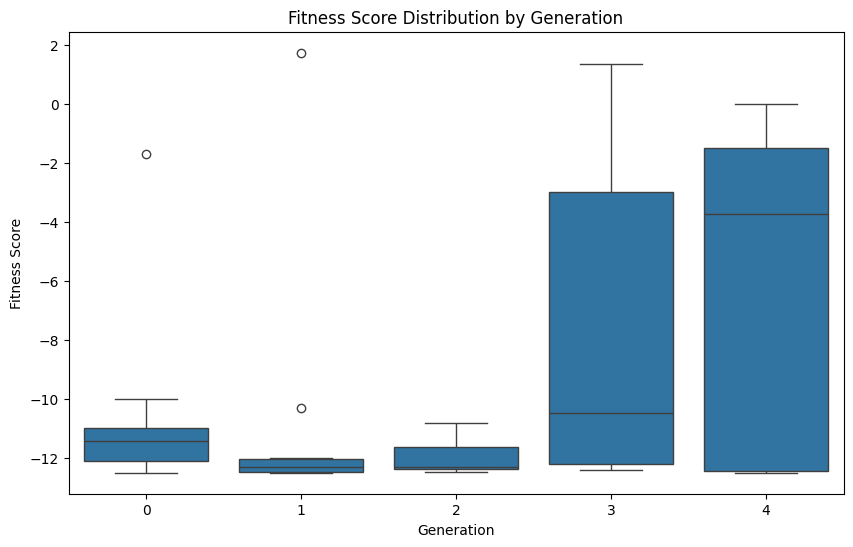

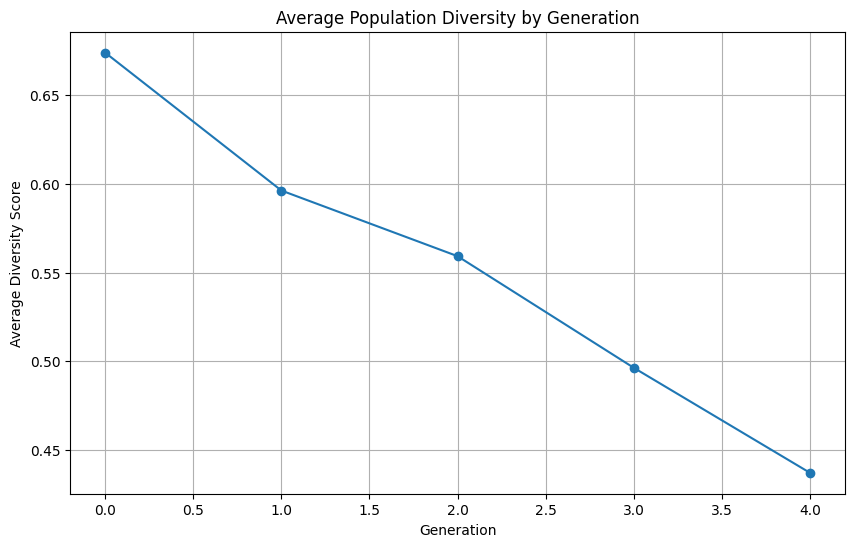

In [15]:
print("\nTuning Results (sorted by fitness score):")
display(results[:5])                                        # Display top 5 results

# Get best performing model details
best_model = results.iloc[0]                                # Get the best model at the top of the sorted results
print("\nBest Model Configuration:")
for param, value in best_model.items():
    print(f"{param}: {value}")

# Plot the evolution of fitness scores across generations
plt.figure(figsize=(10, 6))
sns.boxplot(data=results, x='generation', y='fitness')
plt.title('Fitness Score Distribution by Generation')
plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.show()

# Plot average diversity scores across generations
avg_diversity_by_gen = results.groupby('generation')['diversity_score'].mean()
plt.figure(figsize=(10, 6))
plt.plot(avg_diversity_by_gen.index, avg_diversity_by_gen.values, marker='o')
plt.title('Average Population Diversity by Generation')
plt.xlabel('Generation')
plt.ylabel('Average Diversity Score')
plt.grid(True)
plt.show()

## Part 3: Training Final Model with Best Parameters
The `num_epochs_best_model` flag is designed for user convenience, allowing you to seamlessly extend the training of the best model found during hyperparameter optimization, using its optimal hyperparameters, for a specified number of additional epochs.

However, regardless of whether `num_epochs_best_model` is utilized, you always have the option to:
- Retrieve the optimal hyperparameters identified by the search process.
- Instantiate a new model with these hyperparameters.
- Load the weights of the best model (if desired, or re-initialize and train from scratch).
- Execute an independent training session for any arbitrary number of epochs.

### 3.1 Setup Final Training

Extract and prepare the best parameters for final training:

In [16]:
# Extract best hyperparameters
best_params = {
    'learning_rate': best_model['learning_rate'],
    'lookback': best_model['lookback'],
    'hidden_layers': best_model['hidden_layers'],
    'epsilon_start': best_model['epsilon_start'],
    'epsilon_end': best_model['epsilon_end'],
    'epsilon_decay_epochs_rate': best_model['epsilon_decay_epochs_rate'],
}

# Update the number of training epochs for final training
base_params['num_epochs'] = 100
# Remove num_epochs_best_model from base_params as it is not needed for final training
base_params.pop('num_epochs_best_model', None)

# Combine with base parameters
final_params = {**base_params, **best_params}

print("\nFinal Training Parameters:")
for param, value in final_params.items():
    print(f"{param}: {value}")


Final Training Parameters:
normalize_state: True
eval_noise_factor: 0.1
num_epochs: 100
learning_rate: 0.001
lookback: 10
hidden_layers: [200, 100, 50]
epsilon_start: 0.9
epsilon_end: 0.05
epsilon_decay_epochs_rate: 0.6


### 3.2 Train Final Model

Train a new model using the best parameters found by the genetic algorithm:

In [17]:
# Create dataset
final_dataset = SequentialTimeSeriesDataset(
    data=data_df,
    lookback=best_params['lookback'],
)
dataloader = DataLoader(final_dataset, batch_size=len(final_dataset), shuffle=False, num_workers=0)

# Create agent with best parameters
agent = PolicyGradientAgent(
    full_data=data_df,
    target_column="value",
    output_size=3,
    **final_params
)

# Setup trainer
trainer = L.Trainer(
    max_epochs=base_params['num_epochs'],
    accelerator='auto',
    devices='auto',
    log_every_n_steps=1,
    enable_checkpointing=True,
    logger=L.pytorch.loggers.CSVLogger("logs", name="genetic_tuning_final_model"),
    deterministic=True,
)

print("\nTraining final model with best parameters...")
trainer.fit(agent, dataloader)
print("\nTraining finished.")

print("\nEvaluating final model...")
trainer.validate(model=agent, dataloaders=dataloader)
print("Evaluation finished.")

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | activation_fn | Tanh       | 0      | train
1 | network       | Sequential | 29.5 K | train
-----------------------------------------------------
29.5 K    Trainable params
0         Non-trainable params
29.5 K    Total params
0.118     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytor


Training final model with best parameters...
Epoch 99: 100%|██████████| 1/1 [00:02<00:00,  0.49it/s, v_num=0, train_reward=-0.359, train_loss=-0.449, epsilon=0.050] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:02<00:00,  0.49it/s, v_num=0, train_reward=-0.359, train_loss=-0.449, epsilon=0.050]

c:\Users\Collins P. Ohagwu\anaconda3\envs\tests\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.




Training finished.

Evaluating final model...
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    eval_noise_factor       0.10000000149011612
     val_avg_reward        -0.012178619392216206
   val_pass_percentage       49.39106750488281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Evaluation finished.


### 3.3 Save and Visualize Results

Save the final model and plot the training progress:

Final model saved to: logs\genetic_tuning_final_model\version_0\final_model.ckpt


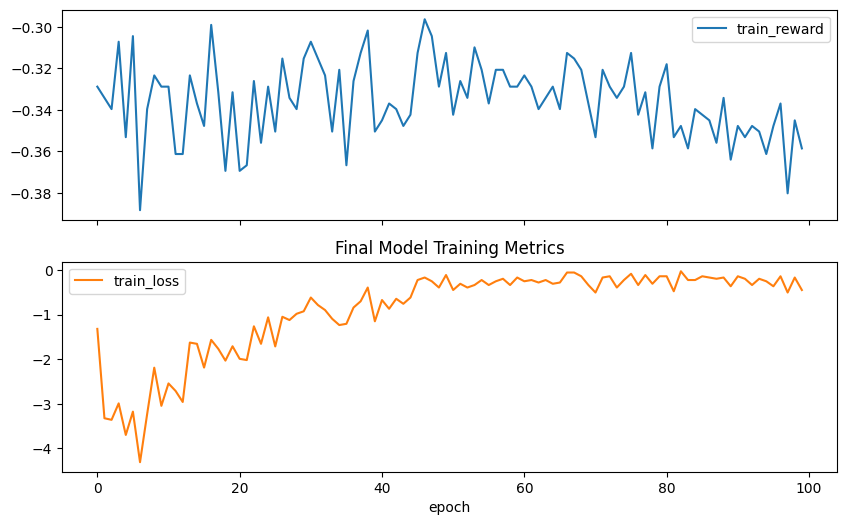

In [18]:
# Save the model
model_dir = trainer.logger.log_dir
trainer.save_checkpoint(os.path.join(model_dir, "final_model.ckpt"))
print(f"Final model saved to: {os.path.join(model_dir, 'final_model.ckpt')}")

# Plot training logs
logs = pd.read_csv(os.path.join(model_dir, "metrics.csv"))
logs.set_index('epoch', inplace=True)
logs[['train_reward', 'train_loss']].plot(subplots=True, figsize=(10, 6))
plt.title("Final Model Training Metrics")
plt.savefig(os.path.join(model_dir, "training_metrics.png"))
plt.show()